# Propensity Score & DML

- Matching

### 질문이나 의견을 남겨주세요.
<script src="https://utteranc.es/client.js"
        repo="CausalInferenceLab/awesome-causal-inference-python"
        issue-term="pathname"
        theme="github-light"
        crossorigin="anonymous"
        async>
</script>

- IPW, AIPW, Doubly Robust Estimator

출처: https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from causalinference import CausalModel

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,5,1,2,0,1,-0.462945,0.652608,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,5,13,1,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,5,2,2,1,0,-2.289636,0.190797,0.875012,-0.724801,0.761781
4488,67,0,0.358336,6,14,1,0,4,-1.115337,1.053089,0.315755,0.054586,1.862187
2637,16,1,1.360920,6,4,1,0,1,-0.538975,1.433826,-0.033161,-0.982274,1.591641


Propensity Score 계산

In [3]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), 
    pd.get_dummies(data[categ], columns=categ, drop_first=False)
], axis=1)

In [4]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

## IPW 생성 및 ATE 추정

In [5]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, Ridge
from causallib.estimation.standardization import Standardization
from causallib.estimation.ipw import IPW
from causallib.estimation.doubly_robust import AIPW

Vanilla IPW

In [6]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10387.611484606225
Untreated Population Sample Size 10391.506082909109


In [7]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1_ipw = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0_ipw = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate_ipw = y1_ipw - y0_ipw
#ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1_ipw)
print("Y0:", y0_ipw)
print("ATE", np.mean(weight * data_ps["achievement_score"]))

Y1: 0.25981028516541704
Y0: -0.12903052853557984
ATE 0.38884081370099727


결과 해석: 
1. Treatment 받은 개인이 Treatment 받지 않은 동료보다 achievement_score가 0.38 표준편차 더 크다. (achievement_score는 표준화된 결과이기 때문에 표준 편차의 차이로 해석)
2. 아무도 Treatment 받지 않은 경우 일반적인 성취 수준이 현재보다 0.12 표준편차 더 낮다.
3. 모든 사람이 Treatment(세미나)를 받았다면 일반적인 성취 수준이 0.25 표준편차 더 높음.

또한 ate를 나타내는 하나의 코드가 더 있다.     
위의 코드에 주석처리한 부분을 그대로 실행해보면 똑같은 결과를 얻을 수 있는 것을 알 수 있다.

In [8]:
ate_ipw = np.mean(weight * data_ps["achievement_score"])
print(ate_ipw)

0.38884081370099727


두 결과값이 같은 이유는 Matheus Facure(출처)의 책에서 자세히 설명되어 있다.    
(참고: $ \mathrm{ATE}=\mathbb{E}\!\left[\, Y\,\dfrac{T-e(X)}{e(X)\,\bigl(1-e(X)\bigr)} \right] $)

## Doubly Robust Estimator & AIPW

출처: https://causallib.readthedocs.io/en/latest/causallib.estimation.doubly_robust.html?highlight=doubly

In [9]:
from sklearn.model_selection import KFold
from causallib.estimation.ipw import IPW
from causallib.estimation.doubly_robust import AIPW
from causallib.estimation.standardization import Standardization
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge

In [10]:
Y = data["achievement_score"]
T = data["intervention"]
X = pd.get_dummies(
    data[["school_mindset","school_achievement","school_ethnic_minority",
          "school_poverty","school_size","ethnicity","gender","school_urbanicity"]],
    drop_first=False
)

DR Estimator는 결과모형과 IPW값이 모두 필요함   
- Y값(achievement_score)을 Ridge로 예측(L2 패널티 부여)   
- IPW: 로지스틱 회귀 사용

In [11]:
outcome_model = Standardization(learner=Ridge(alpha=1.0))
weight_model  = IPW(learner=LogisticRegression(max_iter=1000),
                    clip_min=0.01, clip_max=0.99, use_stabilized=True)

PS Score를 구할 때 max_iter을 충분히 큰 숫자(1000)으로 설정해 수치 최적화가 수렴할 수 있도록 설정합니다.   
또한 클리핑을 사용하여 $ \hat{e} $가 [0.01, 0.99]에서만 존재하도록 극단 가중치를 완화합니다.  
(use_stabilized = True)   

위에서 구한 PS score과 IPW를 활용하여 AIPW를 구합니다. (Vanilla)

In [12]:
dr = AIPW(outcome_model=outcome_model, weight_model=weight_model, overlap_weighting=False)
dr.fit(X, T, Y)

,outcome_model,Standardizati...arner=Ridge())
,weight_model,IPW(_doc_link...ax_iter=1000))
,outcome_covariates,None
,weight_covariates,None
,overlap_weighting,False
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'


In [13]:
pop_outcomes = dr.estimate_population_outcome(X, T, Y)
mu1_aipw, mu0_aipw = pop_outcomes[1], pop_outcomes[0]
ate_aipw = dr.estimate_effect(mu1_aipw, mu0_aipw, agg="population")["diff"]
print("μ1 (A=1):", mu1_aipw)
print("μ0 (A=0):", mu0_aipw)
print("ATE (DR, vanilla):", ate_aipw)

μ1 (A=1): 0.3032993079280466
μ0 (A=0): -0.14711303868200887
ATE (DR, vanilla): 0.45041234661005547


결과 해석은 IPW에서와 마찬가지로 생각하면 됩니다.  

위에서 구한 AIPW는 Propensity Score의 Overlap이 충분히 확보되었을 때는 좋은 결과를 나타냅니다.   
하지만 Overlap 구간이 불안정할 때는 Overlap-weighting = True이라는 기능을 활용해도 좋습니다.

In [14]:
dr_overlap = AIPW(outcome_model=outcome_model,
                  weight_model=weight_model,
                  overlap_weighting=True)
dr_overlap.fit(X, T, Y)

,outcome_model,Standardizati...arner=Ridge())
,weight_model,IPW(_doc_link...ax_iter=1000))
,outcome_covariates,None
,weight_covariates,None
,overlap_weighting,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'


In [15]:
pop_outcomes_ov = dr_overlap.estimate_population_outcome(X, T, Y)
ate_ov = dr_overlap.estimate_effect(pop_outcomes_ov[1], pop_outcomes_ov[0],
                                    agg="population")["diff"]
print(" ATE(DR, overlap-weighting):", ate_ov)

 ATE(DR, overlap-weighting): 0.34674117821712797


### Summary

In [29]:
results = pd.DataFrame([
    ["IPW (manual)",      y1_ipw,    y0_ipw,    ate_ipw],
    ["AIPW (vanilla)",    mu1_aipw,  mu0_aipw,  ate_aipw],
    ["AIPW (overlap)",    np.nan,    np.nan,    ate_ov]
], columns=["estimator", "μ1", "μ0", "ATE"])
print(results)

        estimator        μ1        μ0       ATE
0    IPW (manual)  0.259810 -0.129031  0.388841
1  AIPW (vanilla)  0.303299 -0.147113  0.450412
2  AIPW (overlap)       NaN       NaN  0.346741


위에서 사용한 방법에 따라 ATE 값이 다르게 나타나는 것을 알 수 있습니다.   
  
하지만 Overlap-Weighting 옵션을 사용한 경우에는 ATE가 아닌 ATO를 추정한 것이고 둘을 직접 비교하는 것은 맞지 않을 수 있습니다.   
  
분석의 목적이 ATE를 추정하는 것인지 ATO를 추정하는 것인지 확인한 후 적절히 사용하면 됩니다.   

## IPW Robustness Check의 흐름

각각의 수치에 대한 검증은 필수입니다.  
어떤 수치가 더 Robust하게 추정이 된 걸까요?   

Yang et al., 2019, Gastrointest Endosc 및 Austin, 2021, Statistic in Medicine 논문을 참고하여 IPW에 대한 Robustness Check을 진행해보도록 하겠습니다.    
순서는 다음과 같습니다.

1) **IPW 가중 전, 후 |SMD| 변화 확인**

2) **Propensity Score의 Overlap 확인**

3) **IPW 가중 이후 ESS 및 VIF 확인**

먼저 IPW로 구한 ATE의 신빙성을 테스트 해보겠습니다.

출처: https://causallib.readthedocs.io/en/latest/causallib.evaluation.plots.plots.html

In [40]:
import matplotlib.pyplot as plt
from causallib.evaluation.plots.plots import plot_propensity_score_distribution
from causallib.evaluation import evaluate

### IPW 가중 전, 후 |SMD| 변화 확인

<Axes: xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>

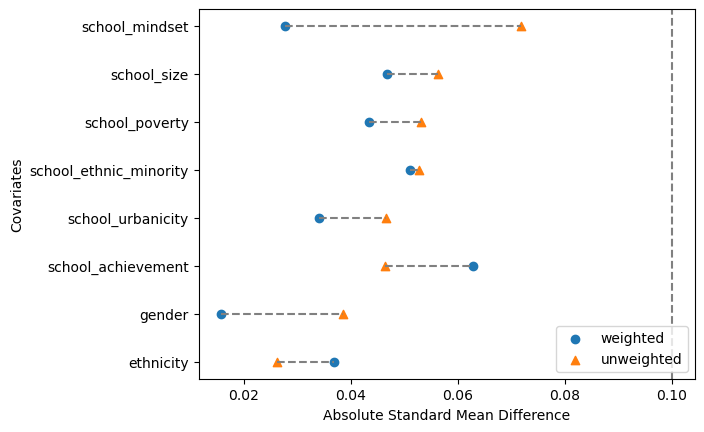

In [66]:
res.plot_covariate_balance(kind="love", phase="valid", thresh=0.1)

Weighted이후에 |SMD|가 더 줄어든 것을 보았을 때, Weighted 이후 밸런스가 개선되었음을 확인할 수 있습니다.    
|SMD| < 0.1 이 목표

### Propensity Score Overlap
아래는 처음에 Logistic Regression으로 추정한 Propensity Score의 Distribution을 나타낸 것입니다.

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

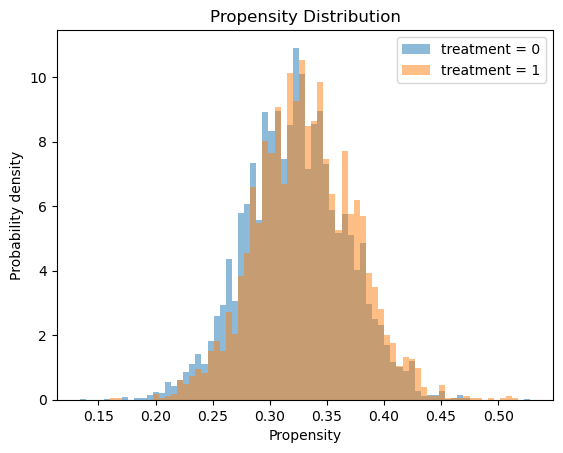

In [50]:
plot_propensity_score_distribution(
    propensity=data_ps['propensity_score'],
    treatment=data_ps['intervention'],
    reflect=False,
    kde=False,
    norm_hist=True,
)

하지만 이는 하나의 데이터에 적합 및 예측을 동시에 하기 때문에 Overlap이 실제보다 좋아보일 수 있습니다.

그렇다면 OOF 폴드 예측으로 얻은 PS 분포를 그려봅시다.   
(cv = None -> 단일 적합, cv = "auto" -> 교차검증)

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

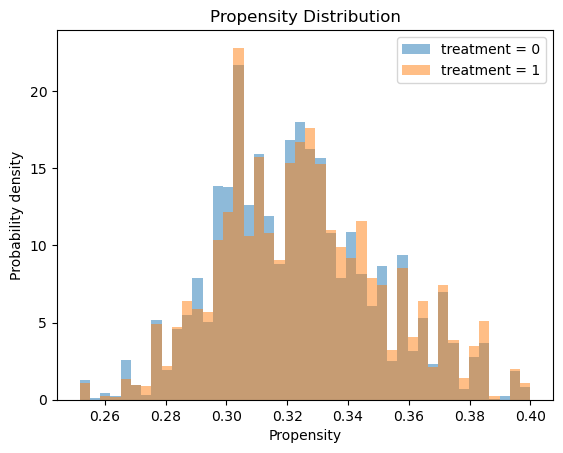

In [55]:
res = evaluate(weight_model, X, T, Y, cv="auto")
res.plot_weight_distribution(phase="valid", reflect=False, norm_hist=True)

OOF로 검증해도 Propensity Score의 Overlap 및 Positivity가 양호한 것을 확인

### IPW 가중치 분포 및 유효표본수(ESS)

In [46]:
w = weight_model.compute_weights(X, T)
ESS = (w.sum()**2) / (w**2).sum()
N   = len(w)
VIF = N / ESS

print(f"ESS = {ESS:.2f} (N = {N})  ->  VIF = {VIF:.4f}")

ESS = 10354.68 (N = 10391)  ->  VIF = 1.0035


Text(0.5, 1.0, 'IPW weights (log y)')

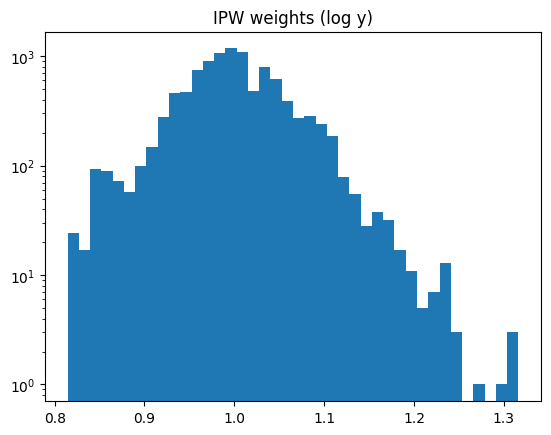

In [47]:
plt.figure(); plt.hist(w, bins=40); plt.yscale('log'); plt.title('IPW weights (log y)')

결과 해석
1) ESS와 N수가 거의 비슷한 것을 확인할 수 있음(VIF ≈ 1) -> 가중치가 고르게 퍼져있다
2) 히스토그램이 1 주변에 모여있고(= 가중치 과도하게 쏠리지 않음), 꼬리 부분도 완만(= 극단 가중치 거의 없음)



다만 VIF와 Propensity Score Overlap이 정량적으로 얼마나 되어야 한다 라는 지표는 찾을 수 없었습니다.    


데이터 및 분석의 맥락에 따라 다르게 지정하되, propensity score의 overlap이 약하다면 위에서 진행한 clipping 등의 방법을 적용해보면 좋습니다. 

## AIPW & DR에 대한 Robustness Check 흐름

AIPW에는 IPW뿐만 아니라 Outcome에 대한 Term이 포함되기 때문에    
**위에서 진행한 IPW에 대한 Robustness Check뿐만 아니라 Outcome에 대한 Robustness Check 및 AIPW 자체에 대한 검사도 함께 진행해야 합니다.**

In [62]:
from causallib.estimation.ipw import IPW
from causallib.estimation.doubly_robust import AIPW
from causallib.estimation.standardization import Standardization
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from causallib.estimation import TMLE

출처: https://causallib.readthedocs.io/en/latest/causallib.estimation.doubly_robust.html?utm_source=chatgpt.com

1) (필수) 부트스트랩 신뢰구간 — AIPW ATE의 추론 견고성

In [50]:
def _aipw_ate_once(Xb, Tb, Yb):
    om = Standardization(learner=Ridge(alpha=1.0))
    wm = IPW(learner=LogisticRegression(max_iter=1000),
             clip_min=0.01, clip_max=0.99, use_stabilized=True)
    dr_b = AIPW(outcome_model=om, weight_model=wm)
    dr_b.fit(Xb, Tb, Yb)
    mu_b = dr_b.estimate_population_outcome(Xb, Tb, Yb)
    return float(dr_b.estimate_effect(mu_b[1], mu_b[0], agg="population")["diff"])

B = 500
rng = np.random.default_rng(42)
n = len(Y)
ates = []
for b in range(B):
    idx = rng.integers(0, n, n)     # 부트스트랩 인덱스
    ates.append(_aipw_ate_once(X.iloc[idx], T.iloc[idx], Y.iloc[idx]))

lo, hi = np.percentile(ates, [2.5, 97.5])
print(f"AIPW ATE 95% bootstrap CI: [{lo:.4f}, {hi:.4f}]")

AIPW ATE 95% bootstrap CI: [0.4139, 0.4879]


2) DR 스트레스 테스트 — 결과모형 및 PS모형 각각 하나씩 변경해보기 

위에서 말했듯 DR에서는 결과모형, PS모형 모두 사용하고 둘 중 하나만 맞으면 결과값이 안정적이라는 장점이 있습니다.     
이러한 DR의 특성을 사용해서 각각의 모형을 하나씩만 바꿨을 때 ATE가 크게 변동이 없으면 모델의 안정성이 확보되는 것으로 해석할 수 있습니다.

In [52]:
base_om = Standardization(learner=Ridge(alpha=1.0))
base_wm = IPW(learner=LogisticRegression(max_iter=1000),
              clip_min=0.01, clip_max=0.99, use_stabilized=True)
dr_base = AIPW(outcome_model=base_om, weight_model=base_wm).fit(X, T, Y)
mu_base = dr_base.estimate_population_outcome(X, T, Y)
ate_base = float(dr_base.estimate_effect(mu_base[1], mu_base[0], agg="population")["diff"])

* 결과 모형만 교체: 비선형 예측기(Random Forest)로 변경

In [53]:
altY_om = Standardization(learner=RandomForestRegressor(n_estimators=400, min_samples_leaf=5, random_state=0))
dr_altY = AIPW(outcome_model=altY_om, weight_model=base_wm).fit(X, T, Y)
mu_altY = dr_altY.estimate_population_outcome(X, T, Y)
ate_altY = float(dr_altY.estimate_effect(mu_altY[1], mu_altY[0], agg="population")["diff"])

* PS모형만 교체: 비선형 분류기 (RF)로 변경

In [56]:
altPS_wm = IPW(learner=RandomForestClassifier(n_estimators=400, min_samples_leaf=5, random_state=0),
               clip_min=0.01, clip_max=0.99, use_stabilized=True)
dr_altPS = AIPW(outcome_model=base_om, weight_model=altPS_wm).fit(X, T, Y)
mu_altPS = dr_altPS.estimate_population_outcome(X, T, Y)
ate_altPS = float(dr_altPS.estimate_effect(mu_altPS[1], mu_altPS[0], agg="population")["diff"])

In [57]:
print({
    "AIPW_ATE_base": ate_base,
    "AIPW_ATE_altY_only": ate_altY,
    "AIPW_ATE_altPS_only": ate_altPS
})

{'AIPW_ATE_base': 0.45041234661005924, 'AIPW_ATE_altY_only': 0.4393682311294207, 'AIPW_ATE_altPS_only': 0.4481943633726966}


ATE의 결과가 변동성이 거의 없는 것을 확인할 수 있습니다.   
-> DR 모형의 안정성 확보

3) TMLE 교차확인 — 같은 DR 계열 추정과 합치하는지 여부 확인

In [61]:
om_tml = Standardization(
    learner=RandomForestRegressor(n_estimators=400, min_samples_leaf=5, random_state=0)
)
wm_tml = IPW(
    learner=LogisticRegression(max_iter=1000, solver='lbfgs'),
    clip_min=0.01, clip_max=0.99,
    use_stabilized=True
)

tmle = TMLE(outcome_model=om_tml, weight_model=wm_tml)
tmle.fit(X, T, Y)

# 핵심: 잠재결과부터 추정
mu_tmle = tmle.estimate_population_outcome(X, T, Y)   # dict 형태, 보통 {0: μ0, 1: μ1}

# 그 다음 효과 계산
ate_tmle = tmle.estimate_effect(mu_tmle[1], mu_tmle[0], agg="population")["diff"]

print("TMLE ATE (cross-check):", float(ate_tmle))
print("AIPW ATE (baseline):   ", float(ate_base))

TMLE ATE (cross-check): 0.4391710324031751
AIPW ATE (baseline):    0.45041234661005924


- Double Machine Learning (비모수 버전의 Regression 처럼 활용 가능)